In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [1]:
import torch
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Diffraction on the different apertures

We will calculate the diffraction of the plane wave on the different apertures using classes from `svetlanna.elements`

## Creating numerical mesh with using `SimulationParameters` class

In [14]:
# screen size
lx = 8 * ureg.mm
ly = 8 * ureg.mm

# distance between the screen and the aperture, mm
z = 220 * ureg.mm

# wavelength, mm
wavelength = 1064 * ureg.nm

# number of nodes
Nx = 1024
Ny = 1024

# creating SimulationParameters exemplar
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [15]:
# return 2d-tensors of x and y coordinates
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Creating a plane wave using `svetlanna.wavefront.plane_wave`

Let's create a plane wave that will fall on the aperture:

In [16]:
# create plane wave
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=0 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Creating round aperture using `svetlanna.elements.RoundAperture` 

In [17]:
radius = 1 * ureg.mm

round_aperture = elements.RoundAperture(
    simulation_parameters=sim_params,
    radius=radius,
)

Let's see the shape of the aperture using `.get_transmission_function()` class method:

In [18]:
aperture_transmission_function = round_aperture.get_transmission_function()

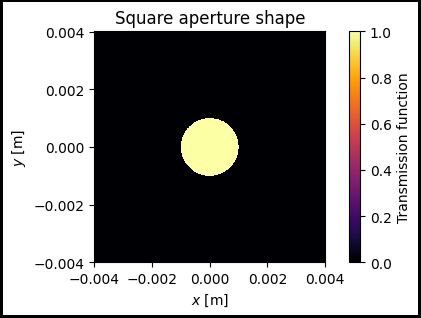

In [19]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, aperture_transmission_function, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Square aperture shape')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Transmission function')

## Intensity profile on the screen after propagation through the round aperture

In this section we will solve the direct problem of diffraction on a round aperture using Angular Spectrum method from `FreeSpace` class

In [20]:
field_after_aperture = round_aperture.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_aperture
)

output_intensity = output_wavefront.intensity

Visualize the intensity distribution:

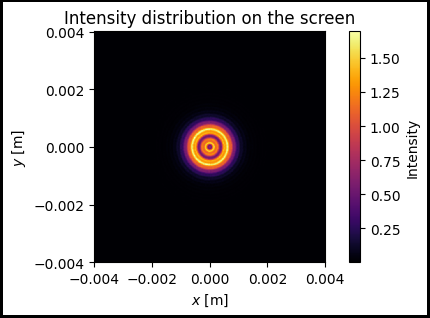

In [21]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, output_intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution on the screen')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Intensity')

## Creating aperture with arbitrary shape

For the instance, we will create the aperture which is similar to the soft aperture from the article [[1]](https://opg.optica.org/ao/abstract.cfm?uri=ao-59-18-5348)

The shape of the aperture is determined by the expression:

$$
r=R + S(\theta)=R(1 + \dfrac{s}{2}(1 + \sin{M\theta})),
$$

where $R$ - radius of the round aperture, $M$ - number of serrations, $s$ - is the ratio of the serrated height $h$ to $r$.

Let's create the shape of the aperture:

In [42]:
radius_soft = 1 * ureg.mm

r = torch.sqrt(x_grid**2 + y_grid**2)
M = 32

s = 0.1

theta = torch.atan2(y_grid, x_grid)
shape = r *( 1 + s / 2 *(1 + torch.sin(M*theta)))
shape = shape < 0.0015

Creating aperture with determined shape using `Aperture` class from the `svetlanna.elements`

In [43]:
soft_aperture = elements.Aperture(simulation_parameters=sim_params, mask=shape)

Let's see the shape of the soft aperture using `.get_transmission_function()` class method:

In [44]:
aperture_transmission_function = soft_aperture.get_transmission_function()

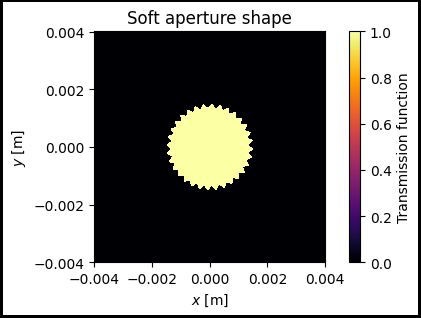

In [46]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, aperture_transmission_function, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Soft aperture shape')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Transmission function')

## Intensity profile on the screen after propagation through the soft aperture

In this section we will solve the direct problem of diffraction on a soft aperture using Angular Spectrum method from `FreeSpace` class

In [47]:
field_after_aperture = soft_aperture.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_aperture
)

output_intensity = output_wavefront.intensity

Visualize the intensity distribution:

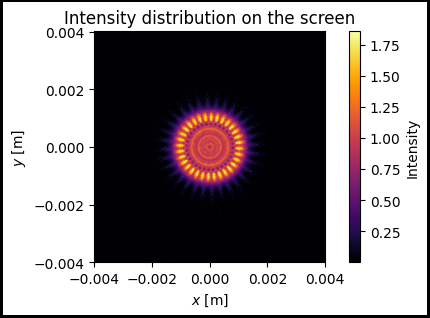

In [48]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, output_intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution on the screen')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Intensity')